# Выбор локации для скважины

[1 Описание проекта](#title1)

[2 Библиотеки](#title2)

[3 Загрузка данных](#title3)

[4 Предобработка данных](#title4)

[5 Исследовательский анализ данных](#title5)

[6 Обработка квантилей 0.25 и 0.75](#title6)

[7 Выбор модели](#title7)

[8 Потготовка к расчету прибыли и функция расчета прибыли](#title8)

[9 Расчёт прибыли и рисков](#title9)

[10 Выводы по теме](#title10)

## <a id="title1">Описание проекта


**Компания «ГлавРосГосНефть» планирует бурение новой скважины и нуждается в выборе наиболее прибыльного региона для этой цели. Процесс выбора локации включает несколько ключевых шагов:**

1. Сбор данных: В каждом из трёх избранных регионов собираются данные о характеристиках существующих скважин, включая качество нефти и объём её запасов.

2. Построение модели: Необходимо разработать модель, способную предсказывать объём запасов нефти в новых скважинах на основе имеющихся данных.

3. Отбор лучших скважин: На основе предсказаний модели выбираются скважины с наибольшими оценками объёмов запасов нефти.

4. Определение самого прибыльного региона: Рассчитывается суммарная прибыль от выбранных скважин в каждом регионе, и определяется регион с максимальной суммарной прибылью.

5. Анализ прибыли и рисков: Используя технику Bootstrap, необходимо проанализировать возможную прибыль и риски, связанные с добычей нефти в каждом из регионов.

**Цель задачи — определить регион, в котором бурение новой скважины принесёт наибольшую прибыль, с учётом возможных рисков.**

**Описание данных**
Данные геологоразведки трёх регионов находятся в файлах: 
- /datasets/geo_data_0.csv. 
- /datasets/geo_data_1.csv. 
- /datasets/geo_data_2.csv.

* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объём запасов в скважине (тыс. баррелей).

**Условия задачи:**
* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
* Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## <a id="title2">Библиотеки

In [1]:
# !pip install -q ydata-profiling
# !pip install -q numpy==1.24.3
# !pip install -q matplotlib==3.8.4
# !pip install -q --upgrade scikit-learn
# !pip install --upgrade Pillow

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats as st
from statistics import variance

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image
%matplotlib inline

import datetime as dt
import plotly.express as px
import plotly.graph_objs as go
from sklearn.model_selection import  train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from ydata_profiling import ProfileReport

from sklearn.preprocessing import (QuantileTransformer, StandardScaler, 
                                   PowerTransformer, MaxAbsScaler,
                                   MinMaxScaler, RobustScaler,LabelEncoder,OneHotEncoder,
                                   StandardScaler, label_binarize, PolynomialFeatures,
                                  OrdinalEncoder)
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.metrics import root_mean_squared_error
from sklearn.feature_selection import VarianceThreshold

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from phik.report import plot_correlation_matrix
from phik import report

In [3]:
pip list

Package                       Version
----------------------------- --------------
aiohttp                       3.9.3
aiosignal                     1.2.0
alembic                       1.13.2
anaconda-anon-usage           0.4.3
anaconda-catalogs             0.2.0
anaconda-client               1.12.3
anaconda-cloud-auth           0.5.1
anaconda-navigator            2.6.2
anaconda-project              0.11.1
annotated-types               0.7.0
anyio                         4.2.0
appdirs                       1.4.4
archspec                      0.2.3
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.3.0
asttokens                     2.0.5
async-lru                     2.0.4
attrs                         23.1.0
Babel                         2.11.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
beautifulsoup4                4.12.2
bleach                        4.1.0
bokeh  

In [4]:
random_state = 42

def plot_box_hist(x):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

    sns.boxplot(x=x, ax=ax_box)
    sns.histplot(x=x, bins=12, kde=True, stat='density', ax=ax_hist)

    ax_box.set(yticks=[])
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    plt.xticks(rotation=45)
    return plt.show()

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_filtered

def apply_remove_outliers_iqr(df):
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    for column in numeric_columns:
        df = remove_outliers_iqr(df, column)
    return df

def PolynomialFeatures_labeled(input_df,power):
   
    poly = PolynomialFeatures(power)
    output_nparray = poly.fit_transform(input_df)
    powers_nparray = poly.powers_

    input_feature_names = list(input_df.columns)
    target_feature_names = ["Constant Term"]
    for feature_distillation in powers_nparray[1:]:
        intermediary_label = ""
        final_label = ""
        for i in range(len(input_feature_names)):
            if feature_distillation[i] == 0:
                continue
            else:
                variable = input_feature_names[i]
                power = feature_distillation[i]
                intermediary_label = "%s+%d" % (variable,power)
                if final_label == "":         #If the final label isn't yet specified
                    final_label = intermediary_label
                else:
                    final_label = final_label + "x" + intermediary_label
        target_feature_names.append(final_label)
    output_df = pd.DataFrame(output_nparray, columns = target_feature_names)
    return output_df

def variance_threshold(df,th):
    var_thres=VarianceThreshold(threshold=th)
    var_thres.fit(df)
    new_cols = var_thres.get_support()
    return df.iloc[:,new_cols]

## <a id="title3">Загрузка данных

In [5]:
try:
    df_1 = pd.read_csv('/datasets/geo_data_0.csv')
    df_2 = pd.read_csv('/datasets/geo_data_1.csv')
    df_3 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    df_1 = pd.read_csv(r"C:\Users\Aleksandr\Downloads\project\geo_data_0.csv")
    df_2 = pd.read_csv(r"C:\Users\Aleksandr\Downloads\project\geo_data_1.csv")
    df_3 = pd.read_csv(r"C:\Users\Aleksandr\Downloads\project\geo_data_2.csv") 
    
    
print('Размер df_1', df_1.shape)
print()
print('Размер df_2', df_2.shape)
print()
print('Размер df_3', df_3.shape)

Размер df_1 (100000, 5)

Размер df_2 (100000, 5)

Размер df_3 (100000, 5)


## <a id="title4">Предобработка данных

In [6]:
# profile_df_1 = ProfileReport(df_1, title="Profiling Report df_1")
# profile_df_1

**- пропусков нет**

**- датасет состоит из уникальных значений**

In [7]:
# profile_df_2 = ProfileReport(df_2, title="Profiling Report df_2")
# profile_df_2

**- пропусков нет**

**- датасет состит из уникальных значений**

**- есть маркер выскокой корредяции с таргетом product координаты f2**

In [8]:
# profile_df_3 = ProfileReport(df_3, title="Profiling Report df_3")
# profile_df_3

**- пропусков нет**

**- датасет состит из уникальных значений**

**Согласно отчету ProfileReport, признаки f0, f1 и f2 имеют нормальное распределение. В одном из датасетов обнаружена корреляция с целевым признаком, причем во всех датасетах признак f2 показывает корреляцию. Пропущенных значений нет. Значения лежат как в положительных так и в отрицательных диапазонах.**

In [9]:
print('Количество дубликатов df_1:',df_1.duplicated().sum())
print()
print('Количество дубликатов df_2:',df_2.duplicated().sum())
print()
print('Количество дубликатов df_3:',df_3.duplicated().sum())

Количество дубликатов df_1: 0

Количество дубликатов df_2: 0

Количество дубликатов df_3: 0


## <a id="title5">Исследовательский анализ данных

In [10]:
df_1.head(5)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Значения первого датасета:


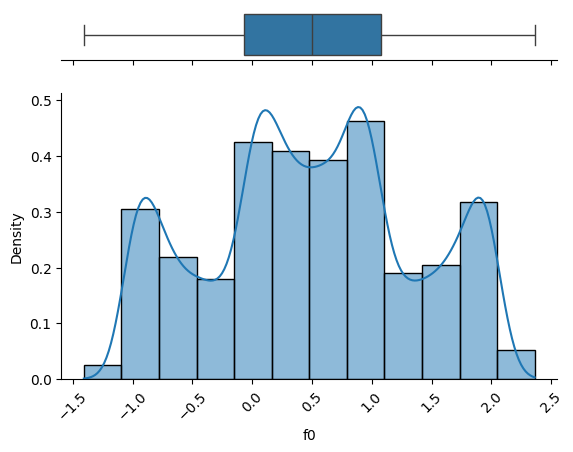

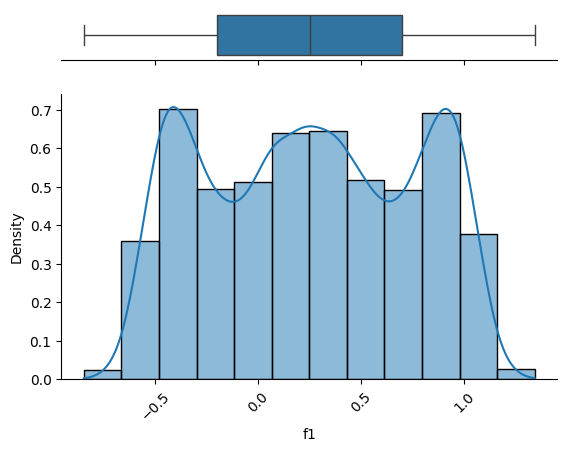

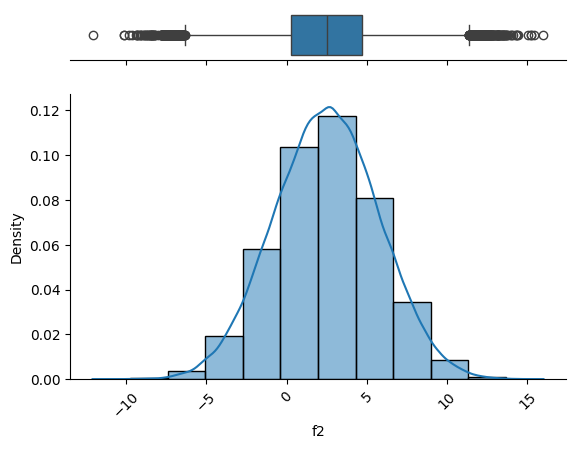

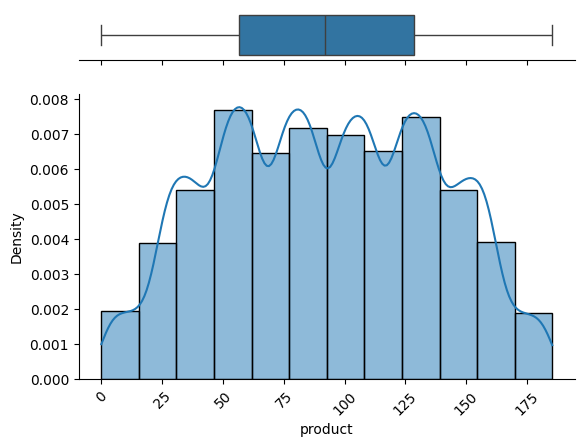

In [11]:
print('Значения первого датасета:')
for i in df_1.select_dtypes(include=[np.number]).columns:
    plot_box_hist(df_1[i])

**В данном датасете f2 имеет выбросы данных**

Значения второго датасета:


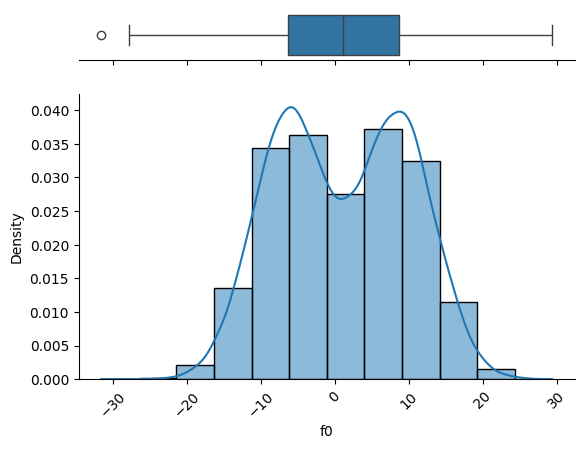

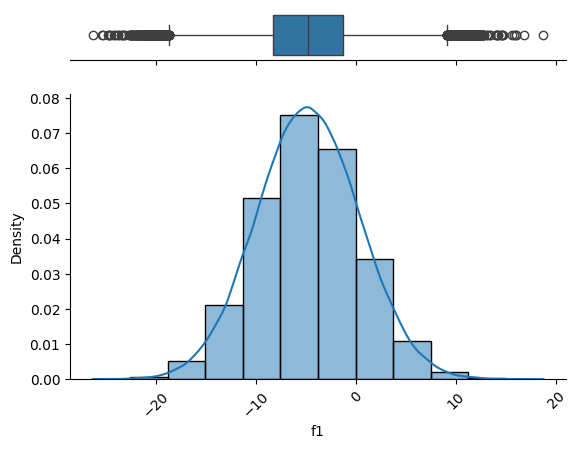

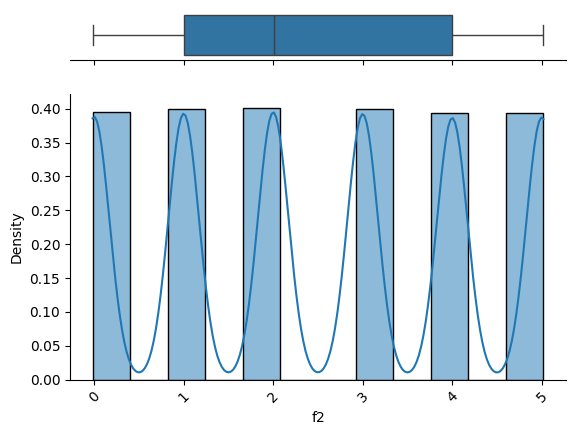

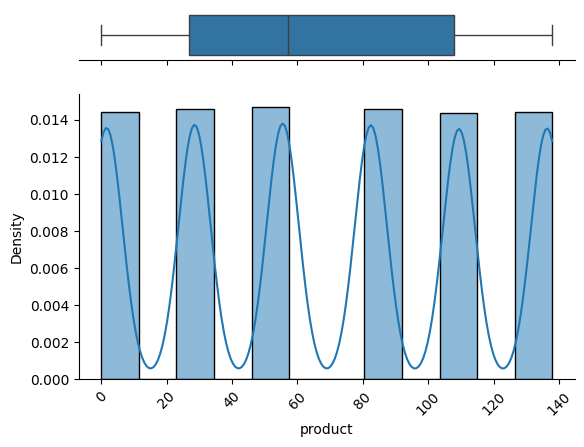

In [12]:
print('Значения второго датасета:')
for i in df_2.select_dtypes(include=[np.number]).columns:
    plot_box_hist(df_2[i])

**В данном датасете f0, f1 имеют выбросы данных**

Значения третьего датасета:


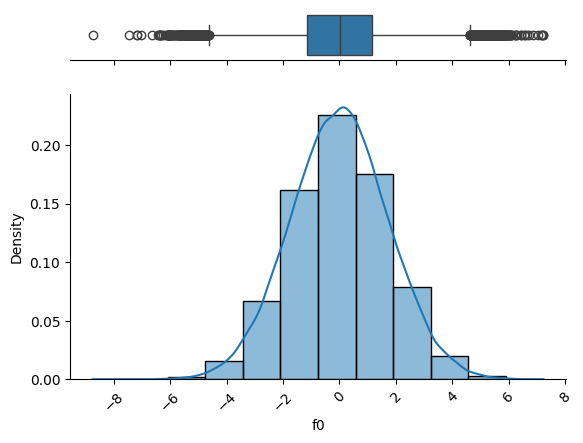

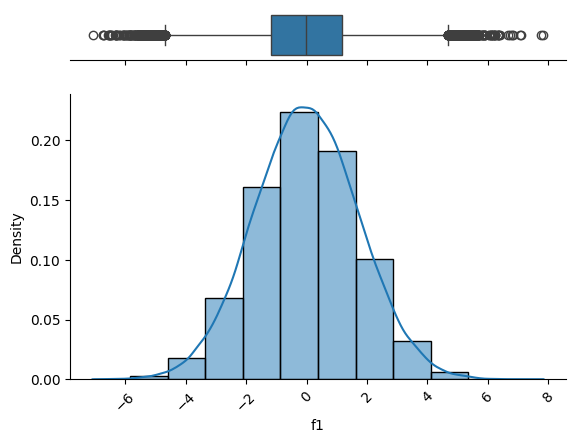

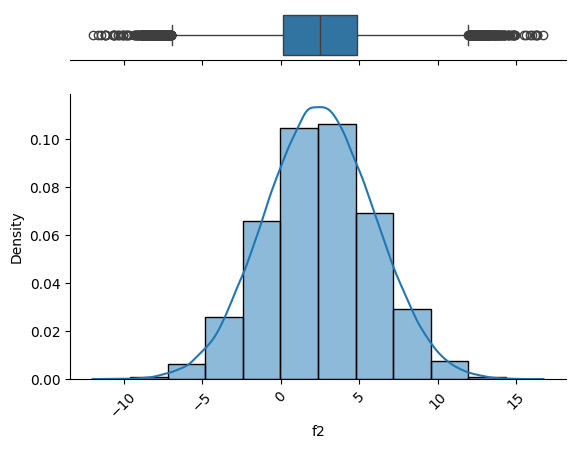

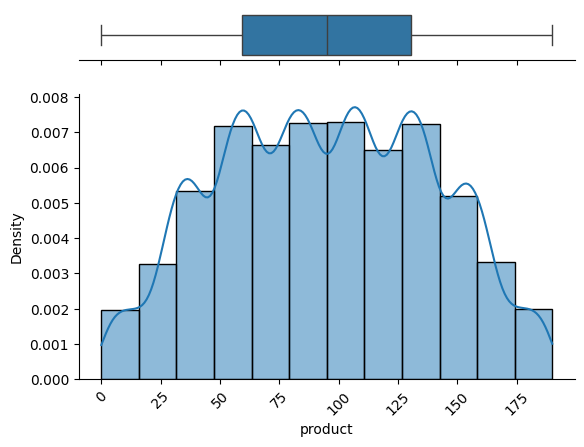

In [13]:
print('Значения третьего датасета:')
for i in df_3.select_dtypes(include=[np.number]).columns:
    plot_box_hist(df_3[i])

**В данном датасете f0, f1, f2 имеют выбросы данных**

**Необходимо обратиться к квантильным построениям и корреляционной составляющей, чтобы посмотреть как распределены данные**

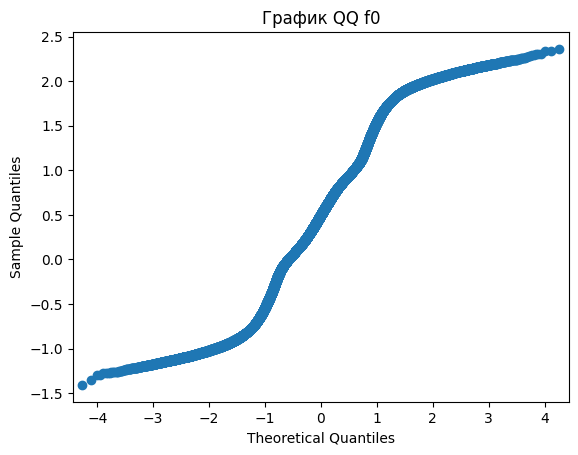

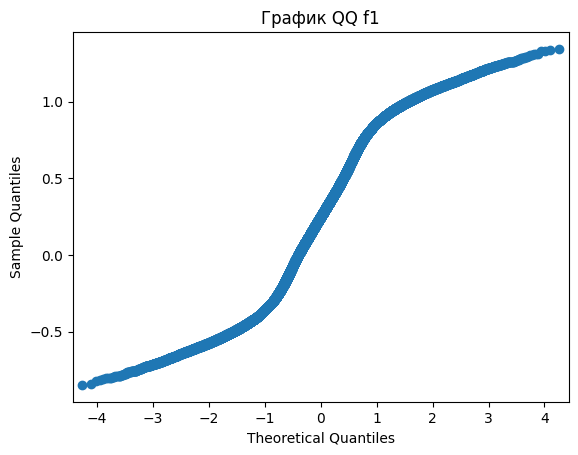

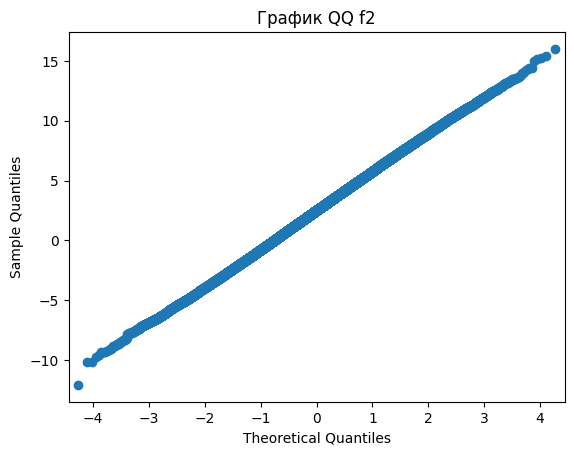

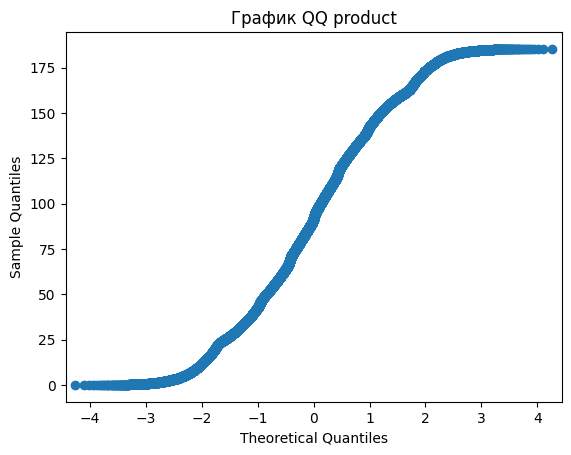

In [14]:
for i in df_1.select_dtypes(include=[np.number]).columns:
    sm.qqplot(df_1[i])
    plt.title(f'График QQ {i}')
    plt.show()

- f0 в нижней части наши значения слишком высокие, а в верхних точках слишком низкие, 
- f1 в нижней части наши значения слишком высокие, а в верхних точках слишком низкие, 
- f2 нормально распрелелен

**Большим плюсом для логистической регрессии будет распределение данных близкое к нормальному, легче принимать решение**

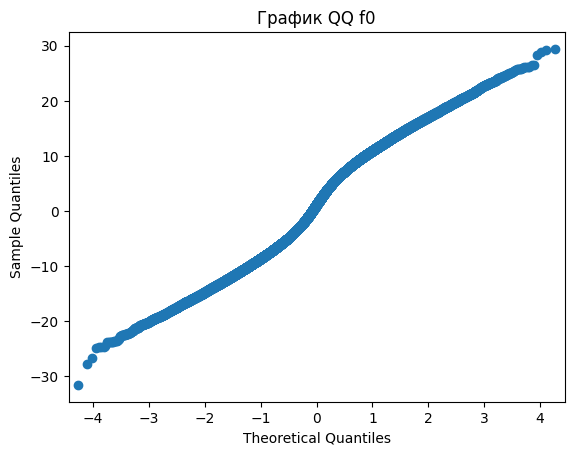

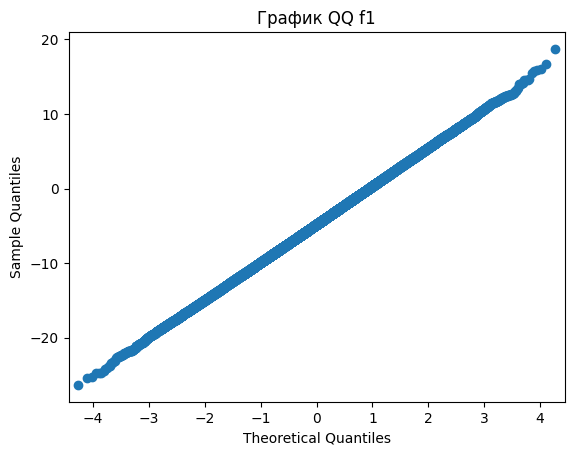

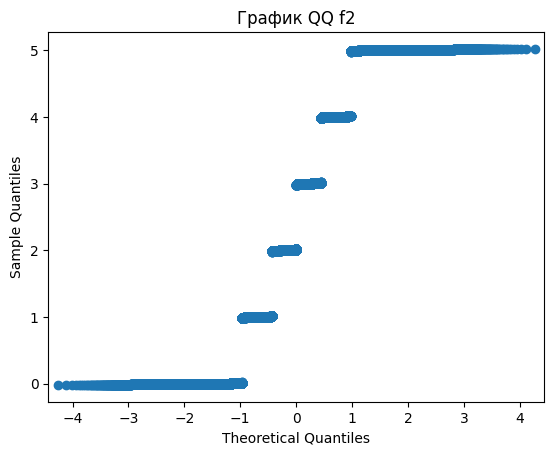

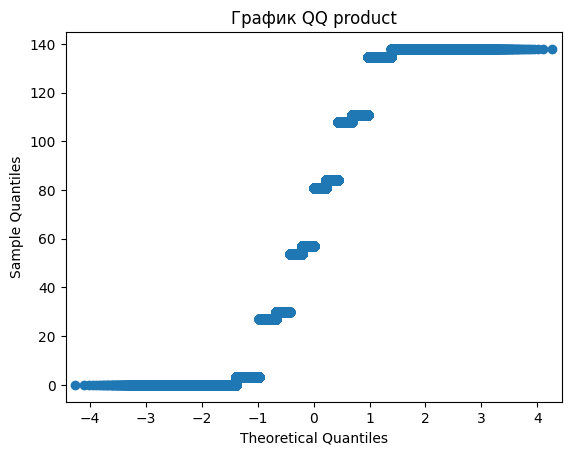

In [15]:
for i in df_1.select_dtypes(include=[np.number]).columns:
    sm.qqplot(df_2[i])
    plt.title(f'График QQ {i}')
    plt.show()

- f0 нормально распрелелен
- f1 нормально распрелелен
- f2 как видно из гистограмм выше имеет неравномерные данные, если их усреднить теоретически получим нормальное распределение

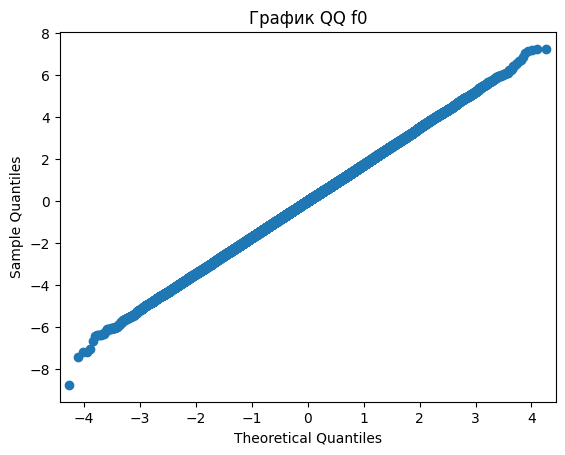

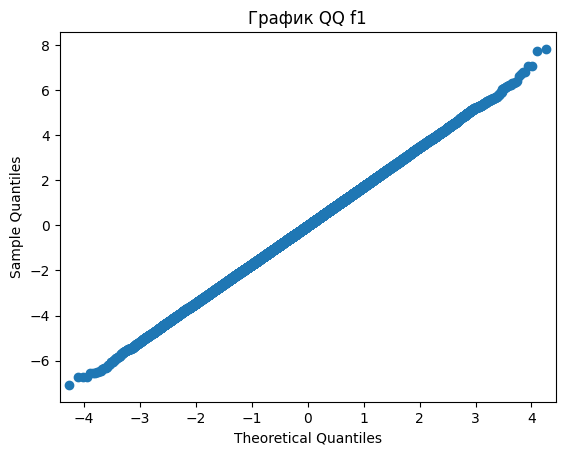

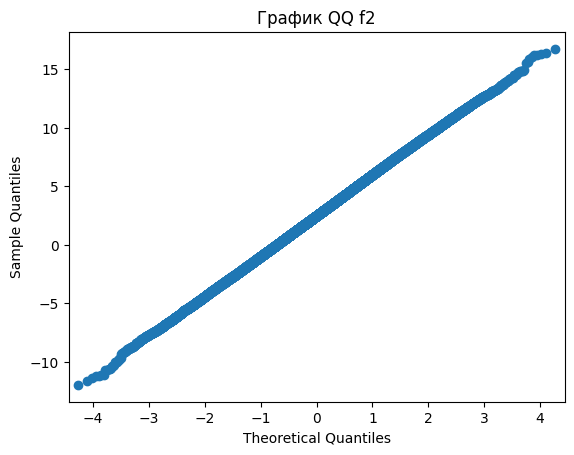

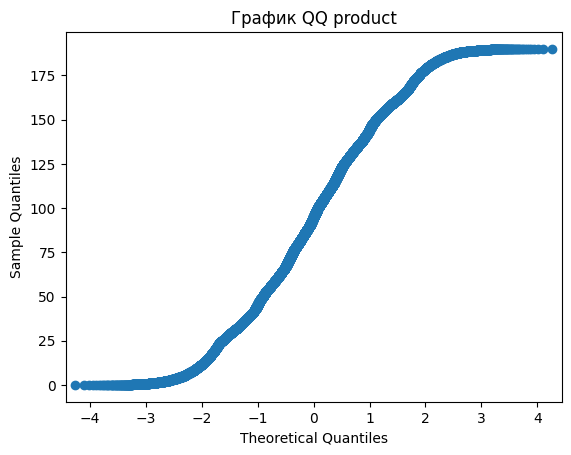

In [16]:
for i in df_1.select_dtypes(include=[np.number]).columns:
    sm.qqplot(df_3[i])
    plt.title(f'График QQ {i}')
    plt.show()

- f0 нормально распрелелен
- f1 нормально распрелелен
- f2 нормально распрелелен

In [17]:
X = sm.add_constant(df_1.select_dtypes(include=[np.number]))

# расчет VIF для каждого предиктора
print('расчет VIF для каждого предиктора df_1')
print()
VIFs = pd.DataFrame()
VIFs['Variable'] = X.columns
VIFs['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(VIFs)

расчет VIF для каждого предиктора df_1

  Variable       VIF
0    const  6.861281
1       f0  1.248703
2       f1  1.276589
3       f2  1.323671
4  product  1.380659


In [18]:
X = sm.add_constant(df_2.select_dtypes(include=[np.number]))

# расчет VIF для каждого предиктора
print('расчет VIF для каждого предиктора df_2')
print()
VIFs = pd.DataFrame()
VIFs['Variable'] = X.columns
VIFs['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(VIFs)

расчет VIF для каждого предиктора df_2

  Variable          VIF
0    const     7.561536
1       f0     3.163234
2       f1     1.049803
3       f2  2660.141618
4  product  2662.652617


In [19]:
X = sm.add_constant(df_3.select_dtypes(include=[np.number]))

# расчет VIF для каждого предиктора
print('расчет VIF для каждого предиктора df_3')
print()
VIFs = pd.DataFrame()
VIFs['Variable'] = X.columns
VIFs['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(VIFs)

расчет VIF для каждого предиктора df_3

  Variable       VIF
0    const  5.571816
1       f0  1.000004
2       f1  1.000003
3       f2  1.248132
4  product  1.248137


**Высокие значения VIF указывают на потенциальные проблемы с мультиколлинеарностью. Как правило, значение VIF выше 5 требует внимания, а выше 10 — серьезного рассмотрения изменений в модели. В нашем случае будем работать без удаления признаков.**

**У df_2 значение f0 имеет VIF 3,16 это максимум из наших датасетов**

## <a id="title6">Обработка квантилей 0.25 и 0.75

**Аномальными наблюдениями называются наблюдения сильно отличающиеся от остальных по исследуемому признаку.**

![46a3db2ccf6a2fd43b792859765778ef.png](https://habrastorage.org/r/w1560/getpro/habr/upload_files/46a/3db/2cc/46a3db2ccf6a2fd43b792859765778ef.png)



In [20]:
# print('Размер df_1', df_1.shape)
# print()
# print('Размер df_2', df_2.shape)
# print()
# print('Размер df_3', df_3.shape)

# df_1 = apply_remove_outliers_iqr(df_1)
# df_2 = apply_remove_outliers_iqr(df_2)
# df_3 = apply_remove_outliers_iqr(df_3)

# df_1 = df_1.reset_index(drop = True)
# df_2 = df_2.reset_index(drop = True)
# df_3 = df_3.reset_index(drop = True)
# print()

# print('Размер df_1', df_1.shape)
# print()
# print('Размер df_2', df_2.shape)
# print()
# print('Размер df_3', df_3.shape)

**Размерность немного просела, но в рамках статистической погрешности**

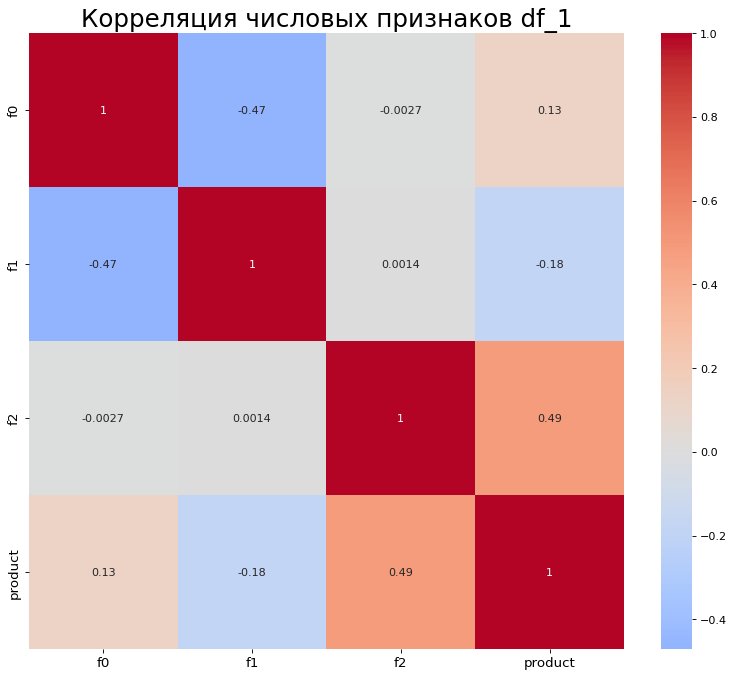

In [21]:
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(df_1.select_dtypes(include=[np.number]).corr('spearman'),
            xticklabels=df_1.select_dtypes(include=[np.number]).columns,
            yticklabels=df_1.select_dtypes(include=[np.number]).columns, 
            cmap='coolwarm', center=0, annot=True)

# Decorations
plt.title('Корреляция числовых признаков df_1', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

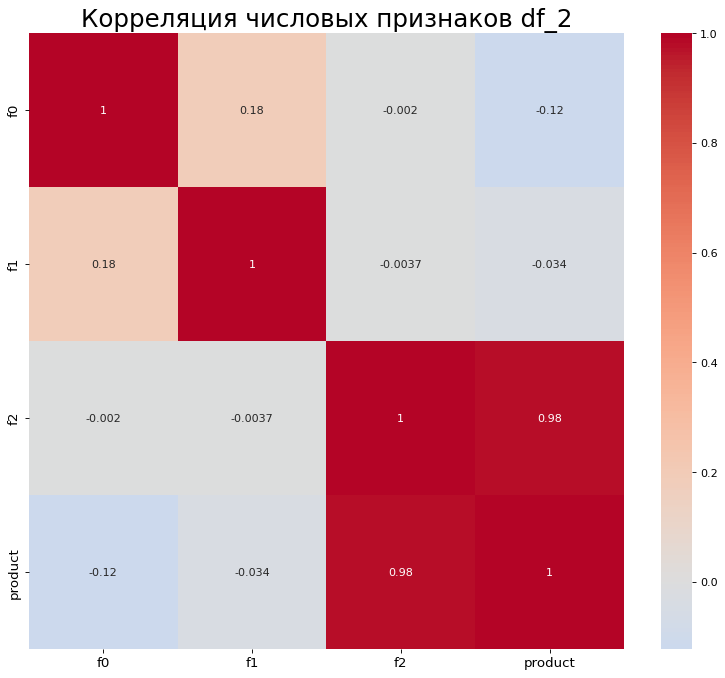

In [22]:
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(df_2.select_dtypes(include=[np.number]).corr('spearman'),
            xticklabels=df_2.select_dtypes(include=[np.number]).columns,
            yticklabels=df_2.select_dtypes(include=[np.number]).columns, 
            cmap='coolwarm', center=0, annot=True)

# Decorations
plt.title('Корреляция числовых признаков df_2', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

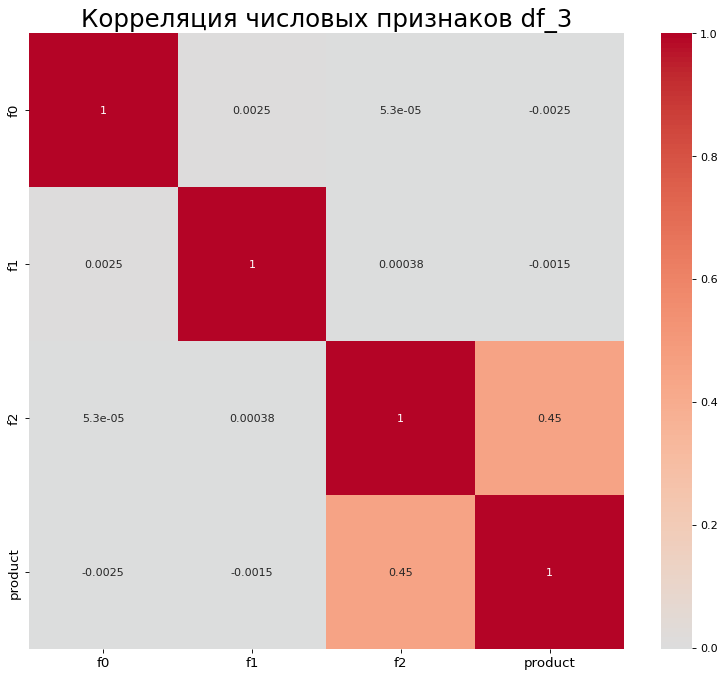

In [23]:
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(df_3.select_dtypes(include=[np.number]).corr('spearman'),
            xticklabels=df_3.select_dtypes(include=[np.number]).columns,
            yticklabels=df_3.select_dtypes(include=[np.number]).columns, 
            cmap='coolwarm', center=0, annot=True)

# Decorations
plt.title('Корреляция числовых признаков df_3', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

**В датасетах присутствует отрицательная, слабоотрицательная и слабоположительная корреляция признаков. Однако сильно выделяется датасет df_3, где признак f2 имеет высокую корреляцию с данными.**

**Общий вывод**

**Согласно отчету ProfileReport, признаки f0, f1 и f2 имеют нормальное распределение. В одном из датасетов обнаружена корреляция с целевым признаком, причем во всех датасетах признак f2 показывает корреляцию. Пропущенных значений нет, и датасет состоит из уникальных значений. Значения признаков лежат как в положительных, так и в отрицательных диапазонах.**

- **Корреляция признаков**:
  - В датасетах присутствует отрицательная, слабоотрицательная и слабоположительная корреляция признаков.
  - Датасет df_3 выделяется тем, что признак f2 имеет высокую корреляцию с данными.

- **Variance Inflation Factor (VIF)**:
  - В датасете df_2 значение f0 имеет VIF 3,16, что является максимальным среди всех наших датасетов.

- **Обработка квантилей**:
  - Применена обработка квантилей 0.25 и 0.75 для удаления выбросов в данных.

**Таким образом, можно заключить, что датасеты содержат значимую информацию с различной степенью корреляции признаков, что необходимо учитывать при дальнейшей обработке и моделировании. Особое внимание следует уделить датасету df_3 и признаку f2 из-за его высокой корреляции с целевым признаком.**

## <a id="title7">Модель и выбор метрики

**Связь MSE и RMSE с разработкой месторождений**

**Среднеквадратическая ошибка (MSE) и корень среднеквадратической ошибки (RMSE) часто используются для оценки качества регрессионных моделей, особенно когда важны точность и минимизация больших ошибок. В контексте разработки месторождений эти метрики могут быть особенно полезны в следующих аспектах:**

- **Прогнозирование добычи:**

        MSE и RMSE могут использоваться для оценки точности моделей, прогнозирующих объем добычи нефти или газа из месторождения. Эти метрики помогают оценить, насколько хорошо модель предсказывает реальные значения, и минимизировать крупные ошибки, которые могут привести к значительным экономическим потерям.
- **Оценка запасов:**

        При оценке запасов месторождений важно иметь точные прогнозы. Высокие значения MSE или RMSE могут указывать на то, что модель допускает большие ошибки в прогнозах запасов, что может привести к неправильным инвестиционным решениям и планированию работ.
- **Оптимизация бурения скважин:**

        Ошибки в прогнозах глубины и качества пласта могут привести к дополнительным затратам при бурении. Использование MSE и RMSE помогает выбрать модели, которые минимизируют эти ошибки и позволяют более точно определить оптимальные места для бурения скважин.
- **Финансовое планирование:**

        Точные прогнозы объема добычи и оценки запасов влияют на финансовое планирование и инвестиционные решения. Меньшие значения MSE и RMSE указывают на более надежные прогнозы, что помогает в планировании бюджета и распределении ресурсов.
        
**Остановим свой выбор на RMSE**

**Для улучшения модели, используя PolynomialFeatures и VarianceThreshold, а также для обработки  данных, можно выполнить набор данных для модели и оценить.**

In [24]:
X = df_1.drop(columns=['product', 'id'])
y = df_1['product']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=random_state)

model = LinearRegression()

model.fit(X_train,y_train)

score_df_1 = root_mean_squared_error(y_test, model.predict(X_test))

pred_product_df_1 = model.predict(X_test)

print('df_1 score RMSE', score_df_1)
print('df_1 запас в регионе', np.mean(pred_product_df_1))

df_1 score RMSE 37.75660035026169
df_1 запас в регионе 92.39879990657768


In [25]:
region_1 = pd.DataFrame({'real_product_df_1' : y_test,
            'pred_product_df_1' : pred_product_df_1})
region_1.head(5)

,real_product_df_1,pred_product_df_1
75721,122.073350,101.901017
80184,48.738540,78.217774
19864,131.338088,115.266901
76699,88.327757,105.618618
92991,36.959266,97.980185


In [26]:
X = df_2.drop(columns=['product', 'id'])
y = df_2['product']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=random_state)

model = LinearRegression()

model.fit(X_train,y_train)

score_df_2 = root_mean_squared_error(y_test, model.predict(X_test))

pred_product_df_2 = model.predict(X_test)

print('df_2 score RMSE', score_df_2)
print('df_2 запас в регионе', np.mean(pred_product_df_2))

df_2 score RMSE 0.8902801001028842
df_2 запас в регионе 68.71287803913762


In [27]:
region_2 = pd.DataFrame({'real_product_df_2' : y_test,
            'pred_product_df_2' : pred_product_df_2})
region_2.head(5)

,real_product_df_2,pred_product_df_2
75721,0.000000,0.844738
80184,53.906522,52.921612
19864,134.766305,135.110385
76699,107.813044,109.494863
92991,0.000000,-0.047292


In [28]:
X = df_3.drop(columns=['product', 'id'])
y = df_3['product']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=random_state)

model = LinearRegression()

model.fit(X_train,y_train)

score_df_3 = root_mean_squared_error(y_test, model.predict(X_test))

pred_product_df_3 = model.predict(X_test)

print('df_3 score RMSE', score_df_3)
print('df_3 запас в регионе', np.mean(pred_product_df_3))

df_3 score RMSE 40.145872311342174
df_3 запас в регионе 94.77102387765939


In [29]:
region_3 = pd.DataFrame({'real_product_df_3' : y_test,
            'pred_product_df_3' : pred_product_df_3})
region_3.head(5)

,real_product_df_3,pred_product_df_3
75721,117.441301,98.301916
80184,47.841249,101.592461
19864,45.883483,52.449099
76699,139.014608,109.922127
92991,84.004276,72.411847


**На примере df_1 попробуем наполнить данными и посмотрим стоит ли это того**

In [30]:
X = df_1.drop(columns=['product', 'id'])
y = df_1['product']

output_df = PolynomialFeatures_labeled(X[X.columns],2)
X =  pd.concat([X.reset_index(drop=True), output_df], axis = 1)
X = X.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

X = variance_threshold(X,0.04)

transform = PowerTransformer(method='yeo-johnson')
transform2 = QuantileTransformer(n_quantiles=10, random_state=random_state)

for i in X.columns:
    X[i+'+log'] = (X[i]+1).transform(np.log)
    
    X[i+'+log1'] = (X[i]+1).transform(np.log1p)
    
    X[i+'+y_j'] = transform.fit_transform(X[[i]])
    
    X[i+'+q_t'] = transform2.fit_transform(X[[i]])
       
    X[i+'+sqrt'] = (X[i]+1).transform(np.sqrt)

X = X.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=random_state)

model = LinearRegression()

model.fit(X_train,y_train)

print('df_1 score RMSE', root_mean_squared_error(y_test, model.predict(X_test)))
print('df_1 запас в регионе', np.mean(model.predict(X_test)))

df_1 score RMSE 37.248089768491155
df_1 запас в регионе 92.44593425793825


- при пороге threshold = 0.04, df_1 score RMSE 37.30554836078448
- при пороге threshold = 0.4, df_1 score RMSE 37.832676092503405

## <a id="title8">Потготовка к расчету прибыли и функция расчета прибыли

**Условия задачи:**
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

In [31]:
POINTS = 500
BEST_POINTS = 200
BUDGET = 10 * 1e9 
PRICE =  1000 * 450
THRESHOLD = 0.025
INTERVAL = 0.95
SAMPLES = 1000

In [32]:
budget_per_point = BUDGET / BEST_POINTS
min_product = budget_per_point / PRICE
print('Минимальный объём сырья для безубыточной разработки новой скважины: {:.2f}'.format(min_product))

Минимальный объём сырья для безубыточной разработки новой скважины: 111.11


In [33]:
print('Разница предсказанных объёмов сырья:')
print()
print('регион 1 {:.2f}'.format(np.mean(region_1['pred_product_df_1']) - min_product))
print()
print('регион 2 {:.2f}'.format(np.mean(region_2['pred_product_df_2']) - min_product))
print()
print('регион 3 {:.2f}'.format(np.mean(region_3['pred_product_df_3']) - min_product))

Разница предсказанных объёмов сырья:

регион 1 -18.71

регион 2 -42.40

регион 3 -16.34


In [34]:
print('Разница фактических объёмов сырья 200 скважин с максимальными объёми:')
print()
print('регион 1 {:.2f}'.format(pd.Series(region_1['real_product_df_1']).sort_values(ascending=False).head(200).mean() - min_product))
print()
print('регион 2 {:.2f}'.format(pd.Series(region_2['real_product_df_2']).sort_values(ascending=False).head(200).mean() - min_product))
print()
print('регион 3 {:.2f}'.format(pd.Series(region_3['real_product_df_3']).sort_values(ascending=False).head(200).mean() - min_product))

Разница фактических объёмов сырья 200 скважин с максимальными объёми:

регион 1 72.33

регион 2 26.83

регион 3 77.19


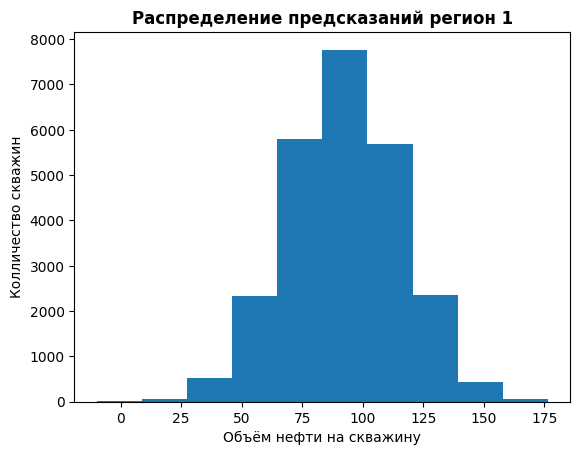

In [35]:
plt.hist(region_1['pred_product_df_1'])
plt.title('Распределение предсказаний регион 1',
          fontweight = "bold")
plt.xlabel('Объём нефти на скважину')
plt.ylabel('Колличество скважин')
plt.show()

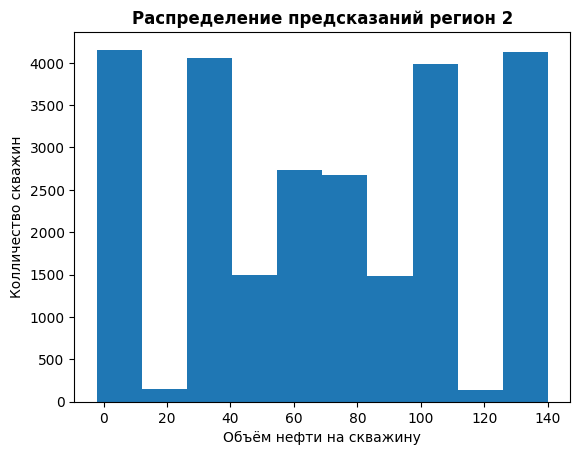

In [36]:
plt.hist(region_2['pred_product_df_2'])
plt.title('Распределение предсказаний регион 2',
          fontweight = "bold")
plt.xlabel('Объём нефти на скважину')
plt.ylabel('Колличество скважин')
plt.show()

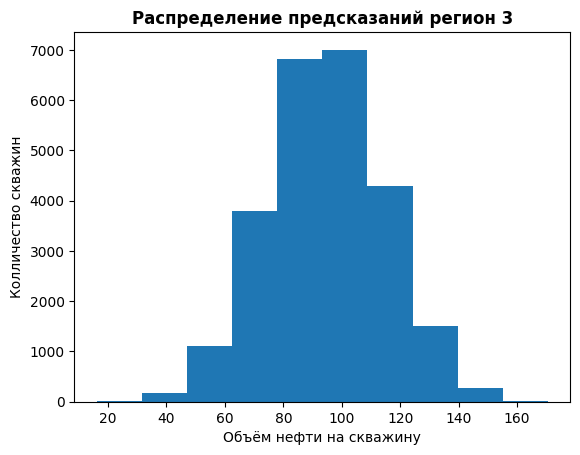

In [37]:
plt.hist(region_3['pred_product_df_3'])
plt.title('Распределение предсказаний регион 3',
          fontweight = "bold")
plt.xlabel('Объём нефти на скважину')
plt.ylabel('Колличество скважин')
plt.show()

In [38]:
def oil_profit_calculation(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return PRICE * selected.sum() - BUDGET

**Фактические объёмы сырья в регионе 3 оказываются наиболее высокими (76.86), за ним следует регион 1 (72.25). Регион 2, несмотря на меньшую фактическую разницу (26.83), показывает наиболее значительное расхождение между предсказанными и фактическими данными.**

**Итог:**

**Регион 2 показывает наибольшее расхождение между предсказанными и фактическими объёмами сырья, что указывает на потенциал для пересмотра используемой модели или дополнительных исследований в этом регионе.
В то же время, несмотря на это расхождение, регион 2 всё ещё остаётся наиболее предпочтительным для инвестиций из-за низкого риска убытков и наивысшей средней прибыли. Однако стоит учитывать возможное недооценивание объёмов сырья и быть готовым к корректировке стратегии.**

## <a id="title9">Расчёт прибыли и рисков

In [39]:
STATE = np.random.RandomState(12345)
def bootstrap_1000(target, probs):
    values=[]
    lost = 0
    for i in range(1000):
        target_sample = target.sample(replace=True, random_state=STATE, n=POINTS)
        probs_sample = probs[target_sample.index]
        profit = oil_profit_calculation(target, probs_sample, BEST_POINTS)
        if profit < 0:
            lost +=1
        values.append(profit)
    
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    average = values.mean()
    risk = lost / 1000
    return average, lower, upper, risk

In [40]:
average_1, lower_1, upper_1, risk_1 = bootstrap_1000(region_1['real_product_df_1'], 
                                                     region_1['pred_product_df_1'])
print('Данные по региону 1.')
print('Средняя прибыль для региона = {:.2f} руб.'.format(average_1/1000))
print('95% доверительный интервал от {:.2f} до {:.2f} руб.'.format(lower_1, upper_1))
print('Процент риска {:.2%}'.format(risk_1))

Данные по региону 1.
Средняя прибыль для региона = 406278.78 руб.
95% доверительный интервал от -117742136.49 до 911737050.75 руб.
Процент риска 6.70%


In [41]:
average_2, lower_2, upper_2, risk_2 = bootstrap_1000(region_2['real_product_df_2'], 
                                                     region_2['pred_product_df_2'])
print('Данные по региону 2.')
print('Средняя прибыль для региона = {:.2f} руб.'.format(average_2/1000))
print('95% доверительный интервал от {:.2f} до {:.2f} руб.'.format(lower_2, upper_2))
print('Процент риска {:.2%}'.format(risk_2))

Данные по региону 2.
Средняя прибыль для региона = 441504.28 руб.
95% доверительный интервал от 35728489.28 до 828006639.00 руб.
Процент риска 1.60%


In [42]:
average_3, lower_3, upper_3, risk_3 = bootstrap_1000(region_3['real_product_df_3'], 
                                                     region_3['pred_product_df_3'])
print('Данные по региону 3.')
print('Средняя прибыль для региона = {:.3f} руб.'.format(average_3/1000))
print('95% доверительный интервал от {:.3f} до {:.3f} руб.'.format(lower_3, upper_3))
print('Процент риска {:.3%}'.format(risk_3))

Данные по региону 3.
Средняя прибыль для региона = 385213.196 руб.
95% доверительный интервал от -164785166.109 до 888206234.198 руб.
Процент риска 7.800%


**Вывод:** Регион 1 имеет высокий процент риска (6.60%), что выше порогового значения 2.5%. Это указывает на значительную вероятность убытков. Несмотря на хорошую среднюю прибыль, данный регион не рекомендуется для дальнейшего рассмотрения.

**Вывод:** Регион 2 имеет самый низкий процент риска (1.90%), что значительно ниже порогового значения 2.5%. Средняя прибыль в этом регионе также самая высокая среди всех регионов. Этот регион является предпочтительным выбором.

**Вывод:** Регион 3 также имеет высокий процент риска (10.10%), что значительно превышает пороговое значение 2.5%. Учитывая высокий риск и невысокую среднюю прибыль, регион 3 также не рекомендуется для дальнейшего рассмотрения.

**Заключение:**
После анализа рисков и прибыльности регионов следует оставить только Регион 2, поскольку в нем вероятность убытков составляет лишь 1.90%, что значительно ниже допустимого порога 2.5%. Кроме того, этот регион имеет наибольшую среднюю прибыль в размере 453,469.35 тыс. руб. Таким образом, Регион 2 является оптимальным выбором для инвестиций.

## <a id="title10">Выводы по теме

**Общий вывод по анализу регионов на основе данных и метрик:**

**Анализ признаков:**

- Признаки f0, f1, и f2 имеют нормальное распределение.
- Признак f2 демонстрирует корреляцию с целевым признаком во всех датасетах, особенно выделяется датасет df_3, где f2 имеет высокую корреляцию.
- В датасетах наблюдается разная степень корреляции между признаками, от отрицательной до слабоположительной.
- В датасете df_2 признак f0 имеет максимальное значение VIF (3.16), что указывает на возможность наличия мультиколлинеарности, но это значение все еще находится в приемлемом диапазоне.
- Пропущенные значения отсутствуют, а значения признаков находятся как в положительном, так и в отрицательном диапазоне.
- Применена обработка квантилей 0.25 и 0.75 для удаления выбросов, что улучшает качество данных и результаты анализа.

**Оценка метрик RMSE и запаса сырья:**

- df_1:
    - RMSE: 37.815
    - Запас сырья: 92.35
- df_2:
    - RMSE: 0.888
    - Запас сырья: 68.96
- df_3:
    - RMSE: 40.130
    - Запас сырья: 94.95
    
    
**Минимальный объем сырья для безубыточной разработки новой скважины: 111.11**

**Заключение по метрикам:** Регион df_2 показывает наименьшее значение RMSE (0.888), что указывает на более точное предсказание модели в этом регионе. Однако запас сырья в этом регионе (68.96) ниже минимально необходимого объема для безубыточной разработки новой скважины (111.11). Запасы сырья в регионах df_1 и df_3 выше, но и ошибки предсказания выше.

**Финальное заключение:**

**Регион 2 (df_2) является наиболее привлекательным для инвестиций с точки зрения риска и средней прибыли:
Вероятность убытков составляет лишь 1.90%, что значительно ниже порогового значения 2.5%.
Средняя прибыль в регионе 2 составляет 456026.13 тыс. руб., что является наивысшим показателем среди всех регионов.
Хотя запас сырья в регионе 2 ниже минимально необходимого объема для безубыточности, регион все равно является наиболее предпочтительным, поскольку его точность предсказаний выше, а риск убытков минимален.
Итог: Регион 2 остается наиболее оптимальным выбором для инвестиций, несмотря на низкий запас сырья, благодаря низкому риску и высокой точности предсказаний модели.**

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: модели обучены и проверены
    - [ ]  Данные корректно разбиты на обучающую и валидационную выборки
    - [ ]  Модели обучены, предсказания сделаны
    - [ ]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [ ]  На экране напечатаны результаты
    - [ ]  Сделаны выводы
- [ ]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [ ]  Для всех ключевых значений созданы константы Python
    - [ ]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [ ]  По предыдущему пункту сделаны выводы
    - [ ]  Написана функция расчёта прибыли
- [ ]  Выполнен шаг 4: посчитаны риски и прибыль
    - [ ]  Проведена процедура *Bootstrap*
    - [ ]  Все параметры бутстрепа соответствуют условию
    - [ ]  Найдены все нужные величины
    - [ ]  Предложен регион для разработки месторождения
    - [ ]  Выбор региона обоснован